# Statistics on Photometry

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-16
- last update : 2024-02-26 : add z filter
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

# Read pandas dataframe on photometry visits

In [4]:
!ls Data_Auxtel_Photom

ls: cannot access Data_Auxtel_Photom: No such file or directory


In [5]:
#files = [ "Data_Auxtel_Photom/ccdVisitTable_202312.csv"  ]
files = [ "ccdVisitTable_202402.csv"  ]
N = len(files)

In [6]:
if N == 1:
    df = pd.read_csv(files[0], index_col=0, header=0) 
else:
    all_df = [pd.read_csv(files[idx], index_col=0, header=0) for idx in range(N)]
    df = pd.concat(all_df)

In [7]:
df.head()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,...,urcdec,lrcra,lrcdec,nightObs,Time,airmass,tractID,patchID,selectedFlag,dayobsMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,...,-23.978569,239.864202,-24.044875,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295,False,60076
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925330,7.783146,3.989901,7.472743,...,-24.100647,240.010470,-24.080526,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295,False,60076
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,...,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295,False,60076
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482190,27.765863,8.100543,10.701077,7.854048,...,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294,False,60076
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847100,6.745777,23.952093,8.440446,...,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294,False,60076


In [8]:
ccd_visit_table_counts = df.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts_g = df[df["band"] == "g"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_r = df[df["band"] == "r"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_i = df[df["band"] == "i"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_z = df[df["band"] == "z"].groupby(['nightObs']).count()["visitId"]

In [9]:
print(ccd_visit_table_counts)

nightObs  band
20230511  g       85
          i       85
          r       87
20230523  g       13
          i       13
                  ..
20240129  z        4
20240130  g       15
          r       15
          y       15
          z       15
Name: visitId, Length: 147, dtype: int64


In [10]:
ccd_visit_table_counts_z

nightObs
20231121    35
20231127    29
20231128    29
20231129    30
20231130    21
20231204    24
20231205    21
20231206    24
20231211    21
20231212     2
20231214    23
20231215    22
20231219     5
20231220    24
20231221    24
20231222    17
20240129     4
20240130    15
Name: visitId, dtype: int64

### Observation date-time

In [11]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [12]:
[convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index ]

[Timestamp('2023-05-11 00:00:00'),
 Timestamp('2023-05-23 00:00:00'),
 Timestamp('2023-05-24 00:00:00'),
 Timestamp('2023-07-04 00:00:00'),
 Timestamp('2023-07-05 00:00:00'),
 Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-18 00:00:00'),
 Timestamp('2023-07-20 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-08-02 00:00:00'),
 Timestamp('2023-08-03 00:00:00'),
 Timestamp('2023-08-15 00:00:00'),
 Timestamp('2023-08-16 00:00:00'),
 Timestamp('2023-08-17 00:00:00'),
 Timestamp('2023-08-29 00:00:00'),
 Timestamp('2023-09-27 00:00:00'),
 Timestamp('2023-09-28 00:00:00'),
 Timestamp('2023-10-10 00:00:00'),
 Timestamp('2023-10-11 00:00:00'),
 Timestamp('2023-11-07 00:00:00'),
 Timestamp('2023-11-08 00:00:00'),
 Timestamp('2023-11-13 00:00:00'),
 Timestamp('2023-11-14 00:00:00'),
 Timestamp('2023-11-15 00:00:00'),
 Timestamp('2023-11-16 00:00:00'),
 Timestamp('2023-11-20 00:00:00'),
 Timestamp('2023-11-21 00:00:00'),
 Timestamp('2023-11-27 00:00:00'),
 Timestamp('2023-11-

In [13]:
dt_g = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index])
dt_r = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_r.index ])
dt_i = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_i.index ])
dt_z = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_z.index ])

### observation counts

In [14]:
n_g = ccd_visit_table_counts_g.values
n_r = ccd_visit_table_counts_r.values
n_i = ccd_visit_table_counts_i.values
n_z = ccd_visit_table_counts_z.values

In [15]:
n_g_tot = np.sum(n_g)
n_r_tot = np.sum(n_r)
n_i_tot = np.sum(n_i)
n_z_tot = np.sum(n_z)

n_g_min = np.min(n_g)
n_r_min = np.min(n_r)
n_i_min = np.min(n_i)
n_z_min = np.min(n_z)

n_g_max = np.max(n_g)
n_r_max = np.max(n_r)
n_i_max = np.max(n_i)
n_z_max = np.max(n_z)

### Observation count sum

In [16]:
s_g = n_g.cumsum()
s_r = n_r.cumsum()
s_i = n_i.cumsum()
s_z = n_z.cumsum()

## Plot

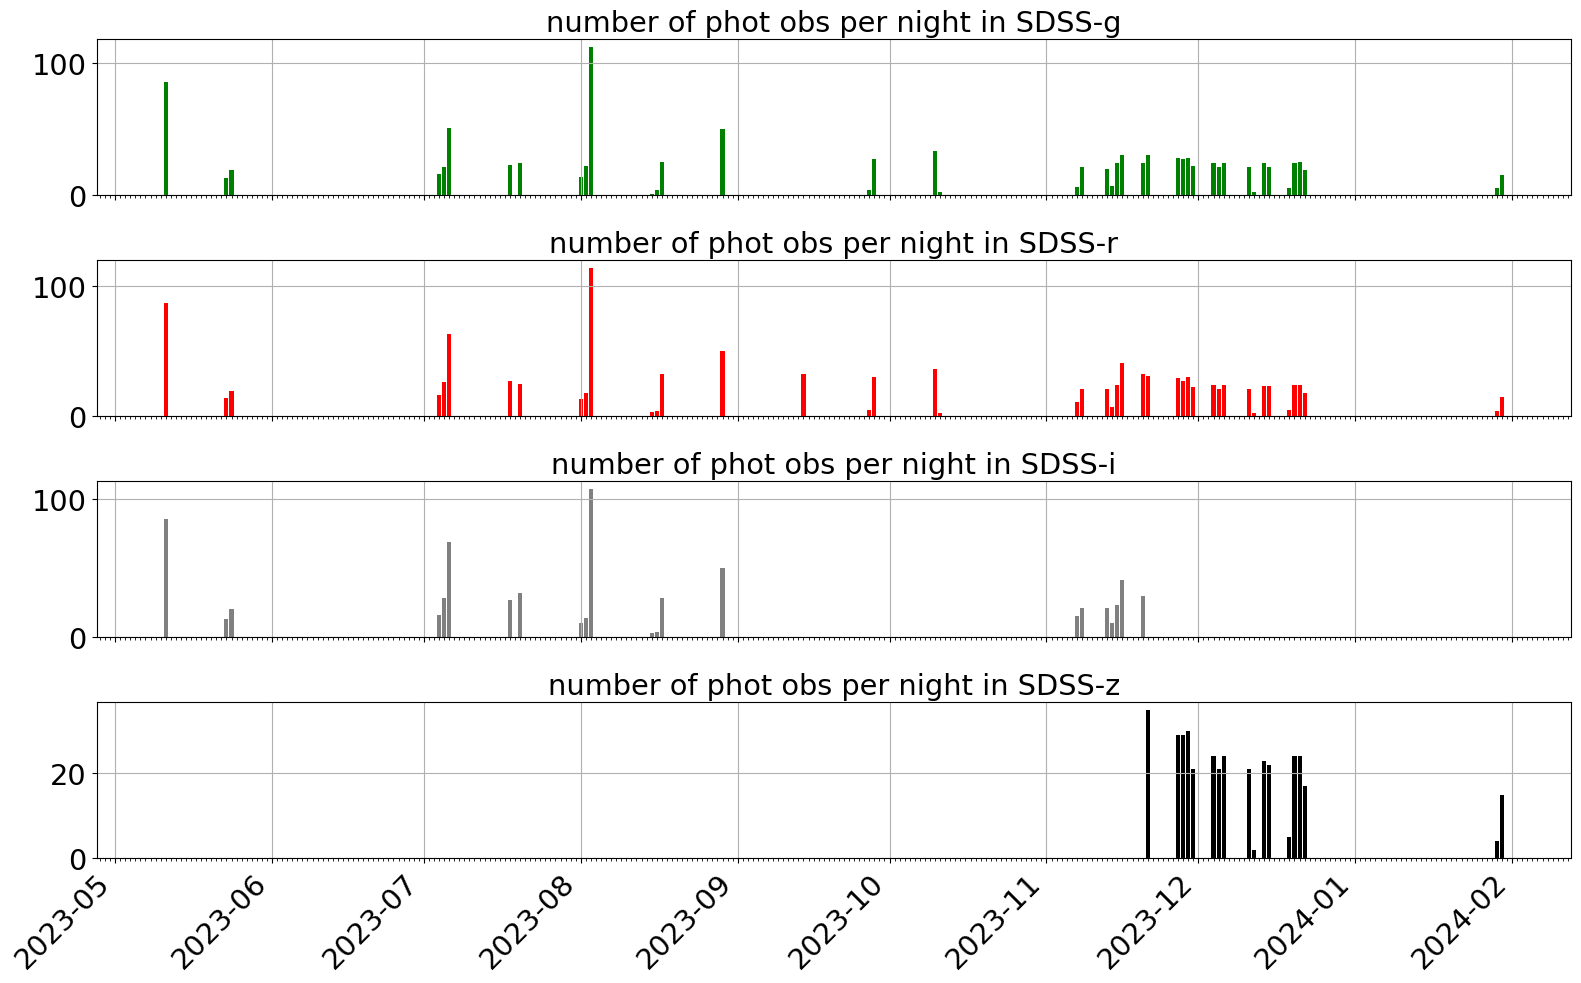

In [17]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(4,1,figsize=(16, 10),sharex=True)

ax1,ax2,ax3,ax4 = axs

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g,n_g,lw=5,facecolor='g')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

title1 = f"number of phot obs per night in SDSS-g"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.bar(dt_r,n_r,lw=5,facecolor='r')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"number of phot obs per night in SDSS-r"
ax2.set_title(title2)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax3.bar(dt_i,n_i,lw=5,facecolor='grey')
ax3.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax3.xaxis.set_minor_locator(day_locator)
ax3.xaxis.set_major_formatter(year_month_formatter)
ax3.grid()

#fig.autofmt_xdate() # rotation
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=45, ha='right')
title3 = f"number of phot obs per night in SDSS-i"
ax3.set_title(title3)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax4.bar(dt_z,n_z,lw=5,facecolor='k')
ax4.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax4.xaxis.set_minor_locator(day_locator)
ax4.xaxis.set_major_formatter(year_month_formatter)
ax4.grid()

#fig.autofmt_xdate() # rotation
ax4.set_xticks(ax4.get_xticks(), ax4.get_xticklabels(), rotation=45, ha='right')
title4 = f"number of phot obs per night in SDSS-z"
ax4.set_title(title4)

plt.tight_layout()

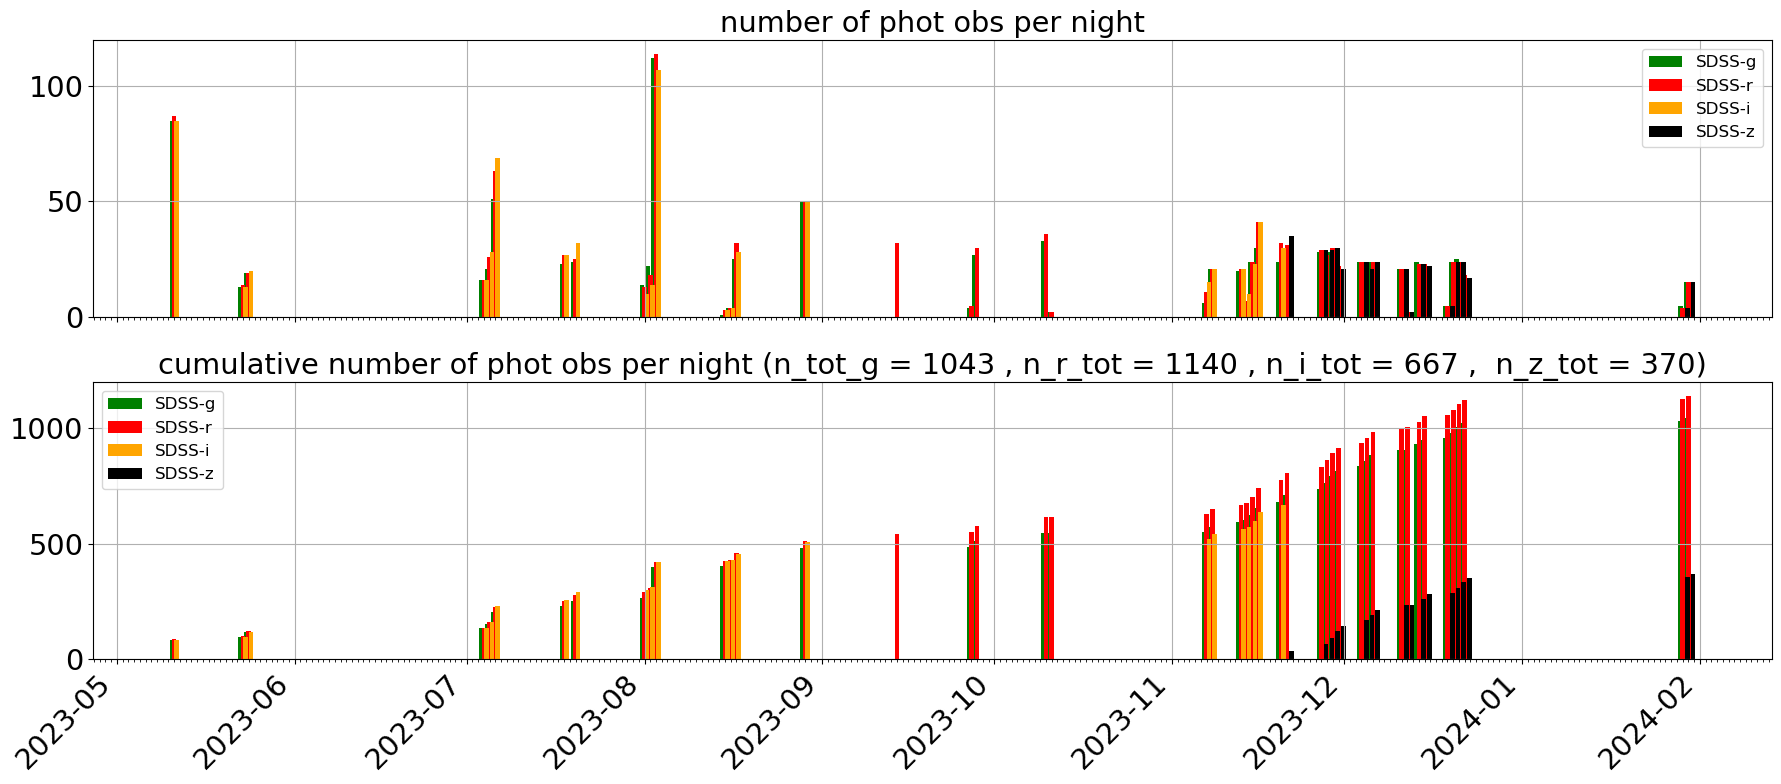

In [18]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(2,1,figsize=(18, 8),sharex=True)

ax1,ax2 = axs

dt = timedelta(hours=10)

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g-dt,n_g,lw=5,facecolor='g',label="SDSS-g")
ax1.bar(dt_r,n_r,lw=5,facecolor='r',label="SDSS-r")
ax1.bar(dt_i+dt,n_i,lw=5,facecolor='orange',label="SDSS-i")
ax1.bar(dt_z+2*dt,n_z,lw=5,facecolor='k',label="SDSS-z")
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax1.legend()
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

title = f"number of phot obs per night"
ax1.set_title(title)


ax2.bar(dt_g-dt,s_g,lw=5,facecolor='g',label="SDSS-g")
ax2.bar(dt_r,s_r,lw=5,facecolor='r',label="SDSS-r")
ax2.bar(dt_i+dt,s_i,lw=5,facecolor='orange',label="SDSS-i")
ax2.bar(dt_z+2*dt,s_z,lw=5,facecolor='k',label="SDSS-z")
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()
ax2.legend()
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')

title = f"cumulative number of phot obs per night (n_tot_g = {n_g_tot} , n_r_tot = {n_r_tot} , n_i_tot = {n_i_tot} ,  n_z_tot = {n_z_tot})"
ax2.set_title(title)


plt.tight_layout()